<a href="https://colab.research.google.com/github/punsnprotons/deep-learning-projects/blob/main/CNN_for_image_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as no
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# training libs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
sns.set(style='white',context='notebook',palette='deep')



In [18]:
train = pd.read_csv('train 2.csv')
test = pd.read_csv('test 2.csv')

In [22]:
Y_train = train['label']
X_train = train.drop(labels=['label'],axis=1)
Y_train.value_counts()


1    4291
7    4049
3    3984
2    3844
9    3823
6    3778
0    3751
8    3729
4    3687
5    3498
Name: label, dtype: int64

## Check for null and missing values

In [23]:
X_train.isnull().any().describe()

count      784
unique       2
top       True
freq       485
dtype: object

In [30]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

The train and test datasets does not have null or missing values

## Gray scale normalization


In [31]:
X_train = X_train/255.0
test = test/255.0

## Reshaping

In [32]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

We use 1 channel at the end since grayscale images only need 1 channel for Keras. We have also converted a 784 pixel 1D row to a 28x28 matrix

## Label Encoding

In [36]:
Y_train.value_counts()

1    4291
7    4049
3    3984
2    3844
9    3823
6    3778
0    3751
8    3729
4    3687
5    3498
Name: label, dtype: int64

In [38]:
Y_train = to_categorical(Y_train, num_classes = 10)


We have one hot encoded the 10 digits from 0 to 9 for **classification**

## Splitting the training and validation set

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=42)

There is no imbalanced representation for the 42,000 training images so a 90/10 split works. Didnt have to set stratify to True for the same reason

## Visualize the training data

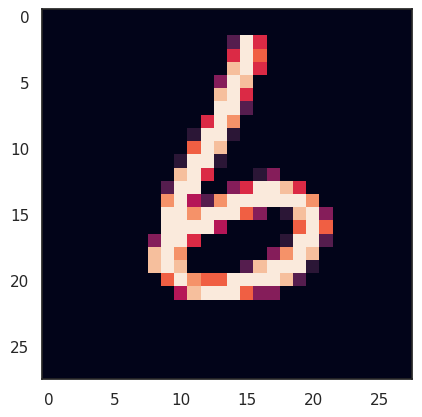

In [43]:
plt.imshow(X_train[0][:,:,0])

## Implementing CNN

*   We take Keras Sequential API to add one layer at a time

*   1st  layer : Conv2D Layer with 32 filters for the two first conv2D layers and 64 filters for the two last one
*   2nd  layer : MaxPool2D as downsampling neighboring pixels and picking maximum values.

*  Dropout regularization is used.
*  ReLU activation functions are used.
*  Flatten layer is used to conver final feature maps to 1D vectors
* Dense output layer with 10 neurons and softmax activation function is used to output probability distribution of each class


In [48]:
model = Sequential()
model.add(Conv2D(
    filters=32,
    kernel_size=(5,5),
    padding='Same',
    activation='relu',
    input_shape=(28,28,1)))

model.add(Conv2D(
    filters=32,
    kernel_size=(5,5),
    padding='Same',
    activation='relu',
    input_shape=(28,28,1)))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(
    filters = 64,
    kernel_size = (3,3),
    padding = 'Same',
    activation = 'relu'))

model.add(Conv2D(
    filters = 64,
    kernel_size = (3,3),
    padding = 'Same',
    activation = 'relu'))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))



## Setting the optmizier and annealer

* We use categorical_crossentropy as the loss function for our caterogical data
* We use RMSprop as our optimizer which reduces the aggresive learning rate of Adagrad method. We could've used the SGD optimizer but its slower compared to RMSprop
* We use accuracy to evaluate the performance of our model



In [62]:
# defining the optimizer
optimizer = RMSprop(learning_rate=0.001,
                    rho=0.9,
                    epsilon=1e-08)
# compile the optimizer , score and loss function into our model
model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
# setting the learning annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_acc',
    patience = 3,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.00001
)
epochs = 1
batch_size = 86

## Data augmentation

We choose to
* Randomly rotate some training images by 10%
* Randomly zoom some training images by 10%
* Randomly shift images horizontally by 10% width
* Randomly shift images vertically by 10% height

In [64]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center=False,
    featurewise_std_normalization =False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)
datagen.fit(X_train)

## Model fitting

In [65]:
history = model.fit_generator(
    datagen.flow(X_train,y_train,batch_size=batch_size),
    epochs = epochs,
    validation_data = (X_test,y_test),
    verbose=2,
    steps_per_epoch=X_train.shape[0]//batch_size,
    callbacks = [learning_rate_reduction]
    )


<ipython-input-65-935eb30a056e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


402/402 - 216s - loss: nan - accuracy: 0.0978 - val_loss: nan - val_accuracy: 0.0960 - lr: 0.0010 - 216s/epoch - 537ms/step


## Model evaluation

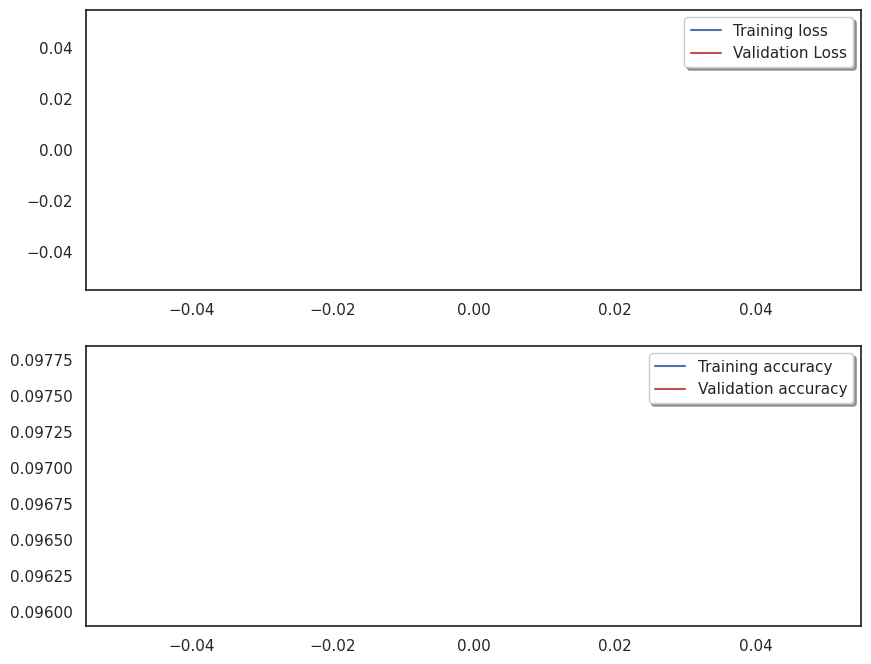

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
legend_loss = ax[0].legend(loc='best', shadow=True)

# Check if 'accuracy' is the correct key
accuracy_key = 'accuracy' if 'accuracy' in history.history else 'acc'

ax[1].plot(history.history[accuracy_key], color='b', label='Training accuracy')
ax[1].plot(history.history['val_' + accuracy_key], color='r', label='Validation accuracy')
legend_acc = ax[1].legend(loc='best', shadow=True)

plt.show()
